# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [2]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.model_selection import train_test_split


![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [3]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [4]:
# Extracting, Transformating

# Converting the shape of X: 
def get_train_test_data(train,test):
    x_train = train['X']
    x_test = test['X']
    
    y_train = train['y']
    y_test = test['y']
    
    # Converting to Categorical Data: 
    # changing label 10 to 0
    y_train[y_train == 10] = 0
    y_test[y_test == 10] = 0
    enc=OneHotEncoder(sparse=False)
    y_train_cat = enc.fit_transform(y_train % 10)
    y_test_cat = enc.fit_transform(y_test % 10)
    


    # Transforming
    x_train = np.transpose(x_train,(3 ,0 ,1,2)) # Shapes the input data
    x_test = np.transpose(x_test,(3 ,0 ,1,2)) # Shapes the input data
    
    
    print(f"Shape of X training Data: {x_train.shape}")
    return x_train,x_test,y_train,y_test,y_train_cat,y_test_cat


In [5]:
# Extracting Data for trainig and testing
x_train,x_test,y_train,y_test,y_train_cat,y_test_cat = get_train_test_data(train,test)


Shape of X training Data: (73257, 32, 32, 3)


In [7]:
# Function for displaying Coloured Images

def display_image_sample(x,y,index):
    
    fig , axs = plt.subplots(3,5)
    
    for index_index , val_index in enumerate(index):
        
        # For colour
        if x.shape[-1] == 3:
            axs.ravel()[index_index].imshow(x[val_index])
        
        else: # For GrayScale
            axs.ravel()[index_index].imshow(x[val_index,:,:,0])
            
        axs.ravel()[index_index].set_title(f"Label: {y[val_index]}")
        axs.ravel()[index_index].set_axis_off()
    
    fig.tight_layout()
    plt.show()

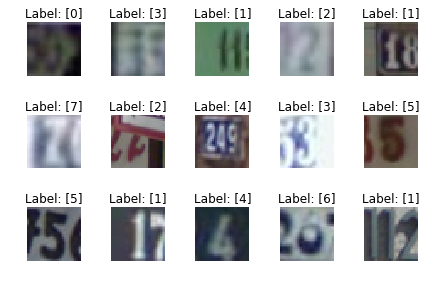

In [9]:
# random sample of images in colour
index = list(np.random.randint(x_train.shape[0],size=(15,)) )
display_image_sample(x_train,y_train,index)

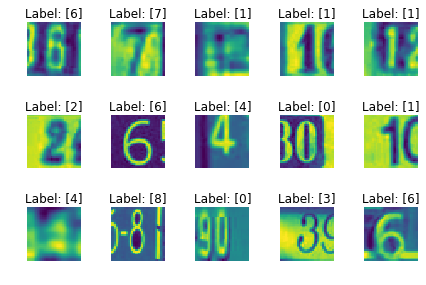

In [7]:
# Reducing the Channel Dimension by creating gray images 
x_train_gray=x_train.mean(axis=-1,keepdims=True)
x_test_gray=x_test.mean(axis=-1,keepdims=True)

# Displaying Random Sample of Images and Labels
index = list(np.random.randint(x_train_gray.shape[0],size=(15,)) )
display_image_sample(x_train_gray,y_train,index)

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [10]:
# Create a Sequential model and Compile
def get_MLP_model(input_shape):
    model = Sequential([
        Flatten(input_shape=input_shape, name = 'Flatten_1'),
        
        Dense(units=128,activation = 'relu',name = 'Dense_1'),
        Dense(units=128,activation = 'relu',name = 'Dense_2'),
        Dense(units=128,activation = 'relu',name = 'Dense_3'),
        Dense(units=128,activation = 'relu',name = 'Dense_4'),

        Dense(units= 10, activation = 'softmax', name = 'Dense_Final')
    ])
    
    model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy','mae']
    )
    
    return model

In [9]:
# Definig Callbacks: 

class my_callback(Callback):

    def on_train_begin(self,logs = None):
        print('START Training ...')
    
    def on_train_end(self,logs = None):
        print('... END of Trainig')
        
def all_callbacks(path):
    # Saving the best weights by monitoring val accuracy
    checkpoint_best_weights = ModelCheckpoint(filepath=path,
                                 save_weights_only=True, save_best_only = True, 
                                 monitor = 'val_accuracy', verbose =1)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience=8,mode='min', verbose = 1)
    
    reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(patience=5, monitor="val_loss")
    
    return checkpoint_best_weights, early_stopping, reduce_learning_rate

In [10]:
def get_evaluation(model,X,y,name):
    loss , accuracy , mae = model.evaluate(X,y, verbose = False)
    print(f'Model {name} Loss: {loss}')
    print(f'Model {name} Accuracy: {accuracy}')

# Ploting 
def ploting_evaluations_history(history):
    df = pd.DataFrame(history.history)
    ax1= df.plot(y= ["loss","val_loss"],use_index = True)
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("loss")
    ax2= df.plot(y= [ "accuracy","val_accuracy"] , use_index = True)
    ax2.set_xlabel("epoch")
    ax2.set_ylabel("accuracy")
    

In [11]:
# Creating New model object
model_mlp = get_MLP_model(x_train_gray[0].shape)

model_mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
Dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
Dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
Dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
Dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
Dense_Final (Dense)          (None, 10)                1290      
Total params: 182,026
Trainable params: 182,026
Non-trainable params: 0
__________________________________________________

In [12]:
# callbacks
checkpoint_best_weights, early_stopping, reduce_learning_rate = all_callbacks('checkpoints_best_only_MLP/checkpoint')

# Using Validation split on Train Data to maintain a holdout test data for evaluation and prediction.
history = model_mlp.fit(x_train_gray,y_train_cat, epochs =25, batch_size= 128,
                    callbacks = [my_callback(),checkpoint_best_weights, early_stopping, reduce_learning_rate],
                    validation_split=0.15)






Train on 62268 samples, validate on 10989 samples
START Training ...
Epoch 1/25
62208/62268 [============================>.] - ETA: 0s - loss: 4.8370 - accuracy: 0.1973 - mae: 0.1693
Epoch 00001: val_accuracy improved from -inf to 0.33534, saving model to checkpoints_best_only_MLP/checkpoint
62268/62268 [==============================] - 22s 356us/sample - loss: 4.8345 - accuracy: 0.1974 - mae: 0.1693 - val_loss: 1.9892 - val_accuracy: 0.3353 - val_mae: 0.1532
Epoch 2/25
62080/62268 [============================>.] - ETA: 0s - loss: 1.7203 - accuracy: 0.4388 - mae: 0.1339
Epoch 00002: val_accuracy improved from 0.33534 to 0.51115, saving model to checkpoints_best_only_MLP/checkpoint
62268/62268 [==============================] - 19s 311us/sample - loss: 1.7193 - accuracy: 0.4390 - mae: 0.1339 - val_loss: 1.5104 - val_accuracy: 0.5111 - val_mae: 0.1205
Epoch 3/25
62208/62268 [============================>.] - ETA: 0s - loss: 1.4101 - accuracy: 0.5523 - mae: 0.1133
Epoch 00003: val_accur

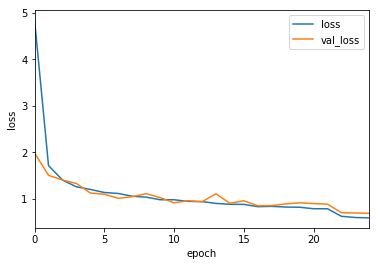

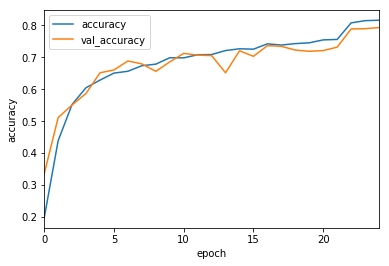

In [13]:
ploting_evaluations_history(history)

In [14]:
# Evaluating the Final Trained model Using Test data
get_evaluation(model_mlp,x_test_gray,y_test_cat,'MLP')

Model MLP Loss: 0.8219168266051374
Model MLP Accuracy: 0.7669790983200073


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [15]:
def get_CNN_model(input_shape):
    model = Sequential([
        Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding='SAME', name = 'conv_1', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2), name = 'pool_1'),
        Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', padding='SAME', name = 'conv_2'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2), name = 'pool_2'),
        
        Conv2D(filters = 8, kernel_size = (3,3), activation = 'relu', padding='SAME', name = 'conv_3'),
        
        Dropout(0.4),

        Flatten(name = 'flatten'),
        
        Dense(units = 64, activation = 'relu', name = 'dense_2'),
        Dense(units = 64, activation = 'relu', name = 'dense_3'),

        Dense(units= 10, activation = 'softmax', name = 'Output'),
    ])
    
    model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy','mae']
    )
    
    return model

In [16]:
model_cnn = get_CNN_model(x_train_gray[0].shape)
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 16, 16, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 16, 16, 16)        4624      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 16)        64        
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 8, 8, 16)          0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 8, 8, 8)          

In [17]:
# Training Model and Validating
checkpoint_best_weights, early_stopping, reduce_learning_rate = all_callbacks('checkpoints_best_only_CNN/checkpoint')

# Using Validation split on Train Data to maintain a holdout test data for evaluation and prediction.
history_cnn = model_cnn.fit(x_train_gray,y_train_cat, epochs =25, batch_size= 128,
                    callbacks = [my_callback(),checkpoint_best_weights, early_stopping, reduce_learning_rate],
                    validation_split=0.15)

Train on 62268 samples, validate on 10989 samples
START Training ...
Epoch 1/25
62208/62268 [============================>.] - ETA: 0s - loss: 1.1617 - accuracy: 0.6128 - mae: 0.1003
Epoch 00001: val_accuracy improved from -inf to 0.80399, saving model to checkpoints_best_only_CNN/checkpoint
62268/62268 [==============================] - 456s 7ms/sample - loss: 1.1615 - accuracy: 0.6128 - mae: 0.1003 - val_loss: 0.6384 - val_accuracy: 0.8040 - val_mae: 0.0574
Epoch 2/25
62208/62268 [============================>.] - ETA: 0s - loss: 0.6630 - accuracy: 0.7917 - mae: 0.0597
Epoch 00002: val_accuracy improved from 0.80399 to 0.84111, saving model to checkpoints_best_only_CNN/checkpoint
62268/62268 [==============================] - 453s 7ms/sample - loss: 0.6631 - accuracy: 0.7917 - mae: 0.0597 - val_loss: 0.5091 - val_accuracy: 0.8411 - val_mae: 0.0467
Epoch 3/25
62208/62268 [============================>.] - ETA: 0s - loss: 0.5774 - accuracy: 0.8170 - mae: 0.0522
Epoch 00003: val_accurac

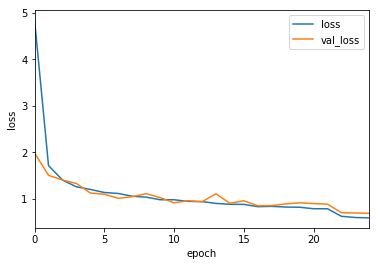

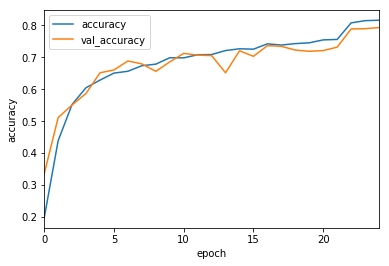

In [18]:
ploting_evaluations_history(history)

In [19]:
get_evaluation(model_cnn,x_test_gray,y_test_cat,'CNN')

Model CNN Loss: 0.33450620018573135
Model CNN Accuracy: 0.9030808210372925


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [20]:
def get_model_best_epoch(model,path):
    """
    This function should create a new instance of the CNN you created earlier, load 
    on the weights leading to the highest validation accuracy, and return this model.
    """
    best_epoch_path = tf.train.latest_checkpoint(path)
    
    model.load_weights(best_epoch_path)
    
    return model

In [21]:
mlp_best = get_model_best_epoch(get_MLP_model(x_train_gray[0].shape),'checkpoints_best_only_MLP/')
cnn_best = get_model_best_epoch(get_CNN_model(x_train_gray[0].shape),'checkpoints_best_only_CNN/')

In [22]:
def display_image_test(model,x,y,index,name):
    
    fig , axs = plt.subplots(5,2 , figsize = (16,12))
    
    predictions_distribution = model.predict(x[index,:,:,:])
    
    pred = np.argmax(predictions_distribution, axis = 1)
    
    for index_index , val_index in enumerate(index):
        axs[index_index, 0].imshow(np.squeeze(x[val_index,:,:,0]))
        axs[index_index, 0].set_title(f"Actual Label: {y[val_index]},  Predicted Label: [{pred[index_index]}]")
        axs[index_index, 0].get_xaxis().set_visible(False)
        axs[index_index, 0].get_yaxis().set_visible(False)
        
        
        axs[index_index, 1].bar(np.arange(len(predictions_distribution[index_index])), predictions_distribution[index_index])
        axs[index_index,1].set_title(f"Distribution of Prediction Model: {name}")
        
        axs[index_index,1].set_xlabel('Labels')
        axs[index_index,1].set_ylabel('p-values')
    
    fig.tight_layout()
    plt.show()

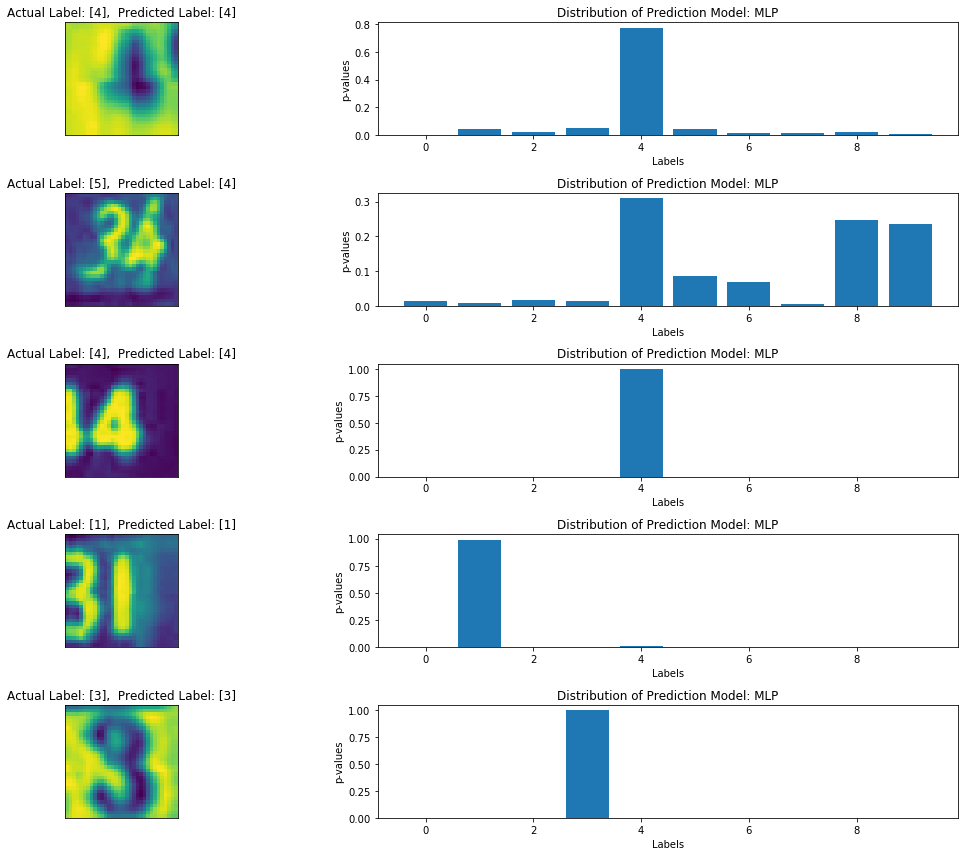

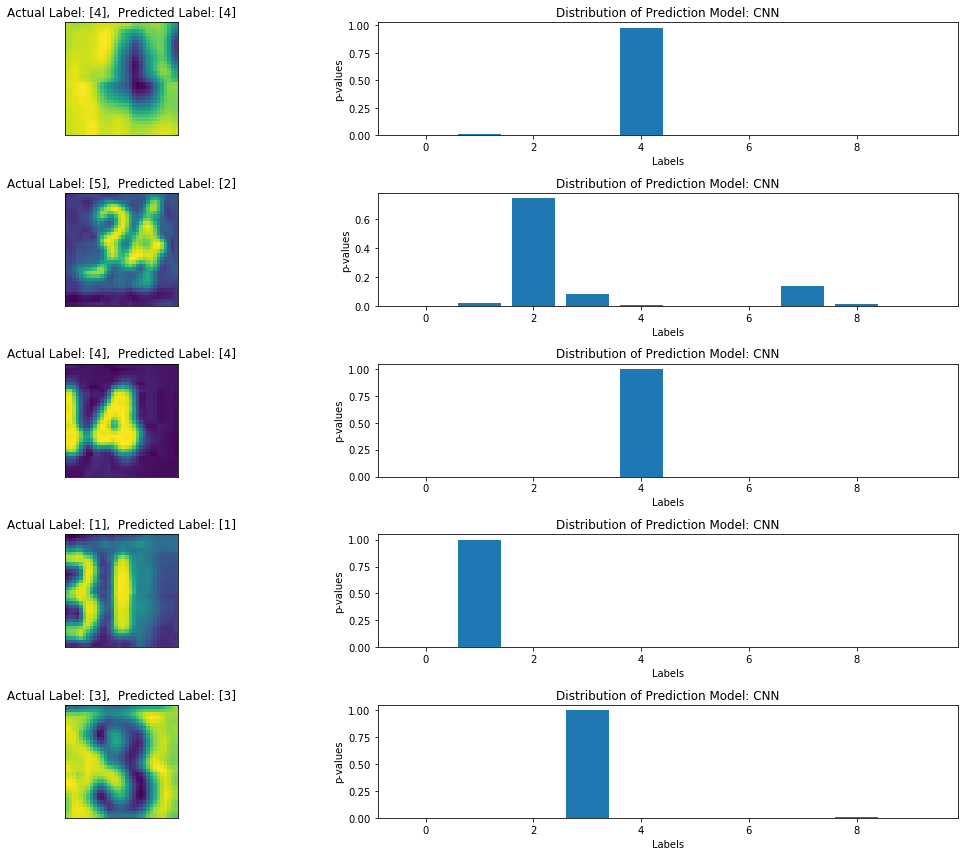

In [23]:
# Image and Labels with prediction on Test Data (holdout data) for MLP and CNN
index = list(np.random.randint(x_test_gray.shape[0],size=(5,)) )
display_image_test(mlp_best,x_test_gray,y_test,index,'MLP')
display_image_test(cnn_best,x_test_gray,y_test,index,'CNN')
